In [609]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np
from bisect import bisect
from tqdm.auto import trange
import gym
import bullet_safety_gym
from sdt.utils import wrap_env
from dsrl.offline_env import OfflineEnvWrapper
from typing import Any, DefaultDict, Dict, List, Optional, Tuple, Union
from collections import defaultdict
# from .autonotebook import tqdm as notebook_tqdm
pd.options.mode.chained_assignment = None  # default='warn'


DIV_LINE_WIDTH = 50

EPISODE_NUM = 20

ENV_NAME_REPLACE = {
    "SafetyAntCircle-v0": "Ant-Circle",
    "SafetyAntRun-v0": "Ant-Run",
    "SafetyCarCircle-v0": "Car-Circle",
    "SafetyCarRun-v0": "Car-Run",
    "SafetyCarReach-v0": "Car-Reach",
    "SafetyDroneCircle-v0": "Drone-Circle",
    "SafetyDroneRun-v0": "Drone-Run",
}
MAX_REWARDS = {'Ant-Run': 683.23785, 
               'Car-Circle': 490.36856, 
               'Car-Run': 574.6547, 
               'Drone-Circle': 852.11084, 
               'Drone-Run': 486.47946, 
               'Car-Reach': 467.5012}

# EXP_NAME_REPLACE = {"bcq_lag": "BCQ-Lag", "cpq": "CPQ", "bear_lag": "BEAR-Lag"}
EXP_NAME_ORDER = ["optimal", "last"]

# COST_NAME = "EpCost"  # "AverageCost"，"EpCost", "NaturalCost"
# REWARD_NAME = "EpRet"  # "AverageReward"， "EpRet", "NaturalReward"
# NOISE_SCALE = 0
# COST_LIMIT = 0

In [610]:
def get_datasets(logdir: str, datasets: dict):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 
    Assumes that any file "progress.txt" is a valid hit. 
    """
    # global NOISE_SCALE, COST_LIMIT
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            
            # config_path = open(os.path.join(root, 'config.json'))
            # config = json.load(config_path)
            
            # NOISE_SCALE = config["noise_scale"]
            # COST_LIMIT = config["cost_limit"]
            env_name = None
            for k, v in ENV_NAME_REPLACE.items():
                if k in root:
                    env_name = ENV_NAME_REPLACE[k]
            if env_name is None:
                continue

            exp_name = "CDT"
            if "eval" not in root:
                continue
            if "CDT/" not in root:
                continue

            # print(f"valid path = {root}")
            exp_data = pd.read_csv(os.path.join(root, 'progress.txt'))
            # exp_data = exp_data.rename(columns=lambda x: x.split("/")[-1])

            if env_name not in datasets.keys():
                datasets[env_name] = {}
            if exp_name not in datasets[env_name].keys():
                datasets[env_name][exp_name] = exp_data
            else:
                datasets[env_name][exp_name] = \
                    pd.concat([datasets[env_name][exp_name], exp_data])

def process_data(exp_data: pd.DataFrame, env_name: str):
    TR = np.arange(0, 1050, 50.).tolist()
    TC = [10.] * len(TR)
    if env_name == "Car-Reach":
        TC = [40.] * len(TR)
    data = np.zeros(( (len(exp_data.keys())-2)//3 , 4))
    n = 0
    tr, tc = [], []
    for i in range(len(TR)):
        name = "TR"+str(TR[i])+"TC"+str(TC[i])
        ret_name  = name+"_EpRet"
        cost_name = name+"_EpCost"
        
        if ret_name not in exp_data.keys():
            continue
        ret = exp_data[ret_name].values / MAX_REWARDS[env_name]
        cost = exp_data[cost_name].values / TC[i]
        
        tr.append(TR[i])
        tc.append(1.0)
        #  - COST_LIMIT
        # cost = np.clip(cost, 0, 1e6)

        # violation = cost > COST_LIMIT
        # # if name == "TR550.0TC10.0":
        # #     print(violation)
        # violation_each_seed = []
        # for j in range(len(violation)//EPISODE_NUM):
        #     # print(j*EPISODE_NUM, (j+1)*EPISODE_NUM)
        #     violation_each_seed.append( np.sum(violation[j*EPISODE_NUM:(j+1)*EPISODE_NUM]) / EPISODE_NUM )
        # violation_rate_mean = np.mean(violation_each_seed) * 100
        # violation_rate_std = np.std(violation_each_seed) * 100

        ret_mean, ret_std = np.mean(ret), np.std(ret)
        cost_mean, cost_std = np.mean(cost), np.std(cost)
        # cost_mean -= COST_LIMIT
        # # cost_mean = np.clip(cost_mean, 0, 1e6)

        data[n, :] = [ret_mean, ret_std, cost_mean, cost_std]
        n += 1
        # data[i, :] = [np.mean(ret), np.std(ret), violation_rate_mean, violation_rate_std]

        # print(f"{name} EpRet = {np.round(ret_mean, 1)} EpCost = {np.mean(cost)}")
        # print("%s EpRet, EpCost = %.3f$\pm$%.3f, %.3f$\pm$%.3f" % (name, ret_mean, ret_std, cost_mean, cost_std))
        print("%s EpRet, EpCost = %.2f, %.2f" % (name, ret_mean*100, cost_mean))
    res = {"data": data, "tr": tr, "tc": tc}
    return res

In [611]:
# exp_data_dirs_optimal = [
#     "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_optimal_eval",
#     "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_optimal_eval",
#     "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_optimal_eval",
#     "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_optimal_eval",
#     "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_optimal_eval",
    
#     # "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_optimal_eval_test",
#     # "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_optimal_eval_test"
# ]

# '''
# CarCircle: seed=0,10,20,30
# DroneRun: seed=0
# '''

# datasets_optimal = {}
# for data_dir in exp_data_dirs_optimal:
#     # read dataset for each env
#     get_datasets(data_dir, datasets_optimal)
# print('='*DIV_LINE_WIDTH)

# for env_name, env_data in datasets_optimal.items():
#     print(env_name)
#     for exp_name, exp_data in env_data.items():
#         # print(len(exp_data["CostLimit"]))
#         data = process_data(exp_data, env_name)
#         env_data[exp_name] = data

In [612]:
exp_data_dirs_last = [
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarReach-v0_last_eval",
]

datasets_last = {}
for data_dir in exp_data_dirs_last:
    # read dataset for each env
    get_datasets(data_dir, datasets_last)
print('='*DIV_LINE_WIDTH)

for env_name, env_data in datasets_last.items():
    print(env_name)
    for exp_name, exp_data in env_data.items():
        # print(len(exp_data["CostLimit"]))
        data = process_data(exp_data, env_name)
        env_data[exp_name] = data

Ant-Run
TR300.0TC10.0 EpRet, EpCost = 46.45, 0.82
TR350.0TC10.0 EpRet, EpCost = 55.18, 0.93
TR400.0TC10.0 EpRet, EpCost = 64.71, 0.78
TR450.0TC10.0 EpRet, EpCost = 70.03, 0.64
TR500.0TC10.0 EpRet, EpCost = 76.09, 0.80
TR550.0TC10.0 EpRet, EpCost = 85.48, 0.89
TR600.0TC10.0 EpRet, EpCost = 92.56, 1.25
TR650.0TC10.0 EpRet, EpCost = 93.40, 1.22
TR700.0TC10.0 EpRet, EpCost = 92.78, 1.12
TR750.0TC10.0 EpRet, EpCost = 92.20, 1.06
TR800.0TC10.0 EpRet, EpCost = 89.76, 0.83
TR850.0TC10.0 EpRet, EpCost = 88.25, 0.82
TR900.0TC10.0 EpRet, EpCost = 87.71, 0.82
TR1000.0TC10.0 EpRet, EpCost = 84.84, 0.72
Car-Circle
TR300.0TC10.0 EpRet, EpCost = 80.09, 1.00
TR350.0TC10.0 EpRet, EpCost = 85.64, 1.33
TR400.0TC10.0 EpRet, EpCost = 88.94, 1.35
TR450.0TC10.0 EpRet, EpCost = 90.48, 1.32
TR500.0TC10.0 EpRet, EpCost = 90.08, 1.08
TR550.0TC10.0 EpRet, EpCost = 89.53, 0.85
TR600.0TC10.0 EpRet, EpCost = 89.05, 0.88
TR650.0TC10.0 EpRet, EpCost = 88.74, 0.79
TR700.0TC10.0 EpRet, EpCost = 88.35, 0.83
TR750.0TC10.0 

In [613]:
'''
Ant-Run: TR800.0TC10.0
Car-Circle: TR550.0TC10.0
Car-Run: TR850.0TC10.0
Drone-Circle: TR850.0TC10.0
Drone-Run: TR550.0TC10.0
Car-Reach: TR350.0TC40.0 
'''

'\nAnt-Run: TR800.0TC10.0\nCar-Circle: TR550.0TC10.0\nCar-Run: TR850.0TC10.0\nDrone-Circle: TR850.0TC10.0\nDrone-Run: TR550.0TC10.0\nCar-Reach: TR350.0TC40.0 \n'

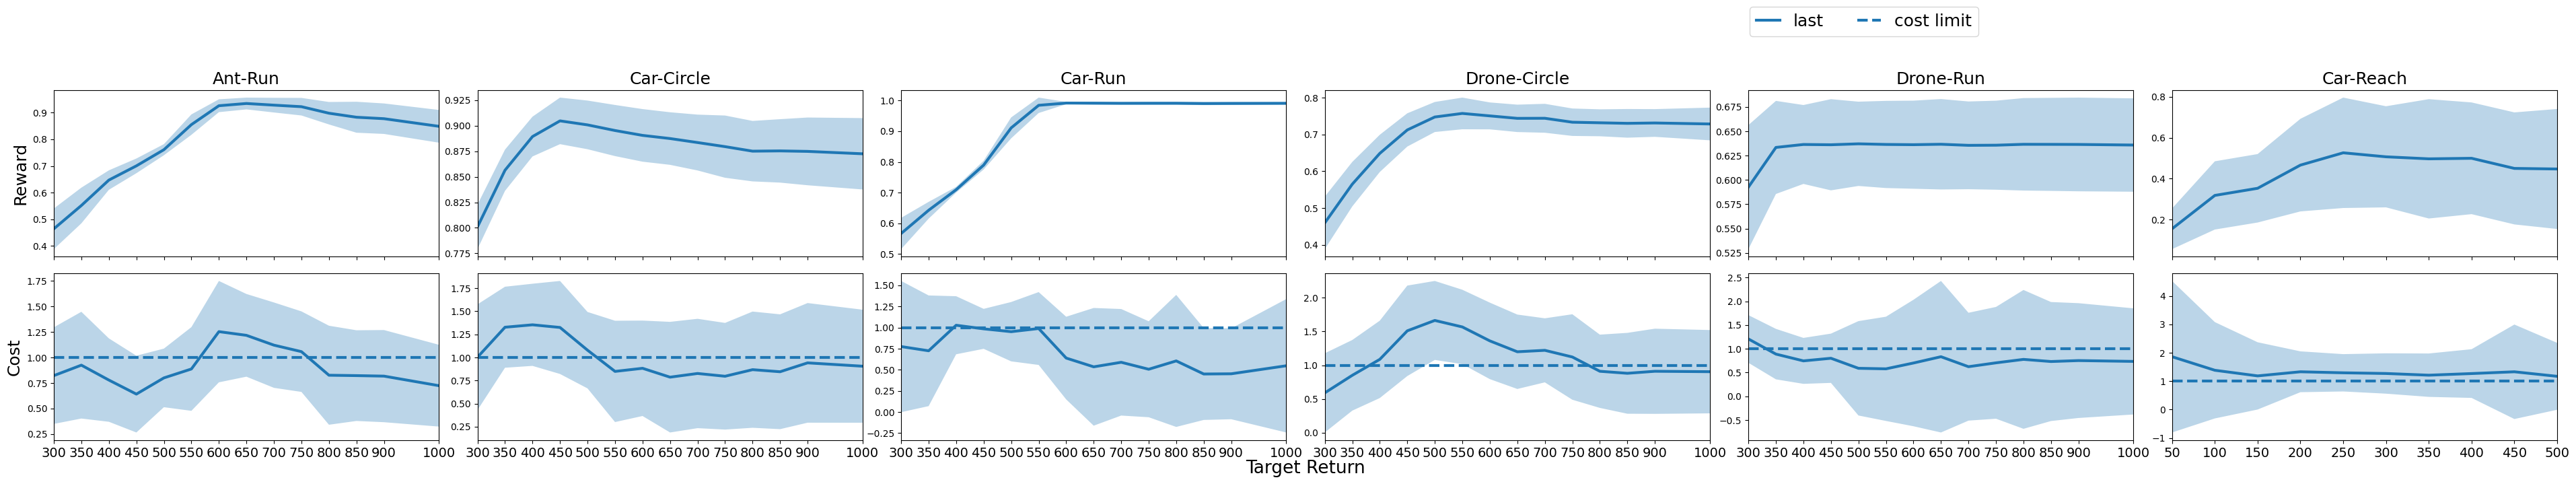

In [614]:
datasets = {"last": datasets_last} # "optimal": datasets_optimal, 

env_names = list(datasets_last.keys())

fontsize = 18
xlabelsize = 14
linewidth = 3
fig = plt.figure(figsize=(len(env_names)*8, 8))
plt.tight_layout()
gs = fig.add_gridspec(2, len(env_names))
axes = gs.subplots(sharex='col')

for nc, env_name in enumerate(env_names):
    
    axes[0, nc].set_title(env_name, fontsize=fontsize)
    if nc == 0:
        axes[0, nc].set_ylabel("Reward", fontsize=fontsize)

    for exp_name in EXP_NAME_ORDER:
        if exp_name not in datasets.keys():
            continue
        # reward
        exp_data = datasets[exp_name][env_name]["CDT"]["data"]
        x = datasets[exp_name][env_name]["CDT"]["tr"]
        cost_limit = datasets[exp_name][env_name]["CDT"]["tc"]
        # print(exp_data)
        # print(f"{exp_name}: reward = {exp_data[0, 1]}, cost = {exp_data[0, 3]}")
        axes[0, nc].plot(x, exp_data[:, 0], label=exp_name, linewidth=linewidth)
        axes[0, nc].fill_between(x, 
                                 exp_data[:, 0]-exp_data[:, 1], 
                                 exp_data[:, 0]+exp_data[:, 1], 
                                 alpha=0.3)
        axes[0, nc].set_xlim(x[0], x[-1])
        axes[0, nc].set_xticks([])
        
        # cost
        axes[1, nc].plot(x, exp_data[:, 2], label=exp_name, linewidth=linewidth)
        axes[1, nc].fill_between(x, 
                                 exp_data[:, 2]-exp_data[:, 3], 
                                 exp_data[:, 2]+exp_data[:, 3], 
                                 alpha=0.3)
        axes[1, nc].set_xlim(x[0], x[-1])
        axes[1, nc].set_xticks(x)

    if nc == 0:
        axes[1, nc].set_ylabel("Cost", fontsize=fontsize)
        # axes[1, nc].set_ylabel("Violation Rate", fontsize=fontsize)
    axes[1, nc].tick_params(axis='x', labelsize=xlabelsize)

    # cost limit
    axes[1, nc].axhline(y=cost_limit[0], linestyle = '--', linewidth=linewidth, label="cost limit")

plt.subplots_adjust(top=0.8, bottom=0.15, wspace=0.2, hspace=0.1)
plt.legend(ncol=len(EXP_NAME_ORDER), loc='best').set_draggable(True)
plt.legend(
        bbox_to_anchor=(-0.8, 2.6),
        loc='upper center',
        ncol=len(EXP_NAME_ORDER)+1,
        handlelength=1.4,
        borderaxespad=0.,
        prop={'size': fontsize}
        )
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Target Return", fontsize=fontsize+1)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.savefig("/home/zijian/codes/robust-safe-rl/script/figure/results.png")


BC-Safe

In [615]:
def get_datasets(logdir: str, datasets: dict):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 
    Assumes that any file "progress.txt" is a valid hit. 
    """
    # global NOISE_SCALE, COST_LIMIT
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:
            
            # config_path = open(os.path.join(root, 'config.json'))
            # config = json.load(config_path)
            
            # NOISE_SCALE = config["noise_scale"]
            # COST_LIMIT = config["cost_limit"]
            env_name = None
            for k, v in ENV_NAME_REPLACE.items():
                if k in root:
                    env_name = ENV_NAME_REPLACE[k]
            if env_name is None:
                continue

            exp_name = "BC-Safe"
            if "eval" not in root:
                continue

            # print(f"valid path = {root}")
            exp_data = pd.read_csv(os.path.join(root, 'progress.txt'))
            # exp_data = exp_data.rename(columns=lambda x: x.split("/")[-1])

            if env_name not in datasets.keys():
                datasets[env_name] = {}
            if exp_name not in datasets[env_name].keys():
                datasets[env_name][exp_name] = exp_data
            else:
                datasets[env_name][exp_name] = \
                    pd.concat([datasets[env_name][exp_name], exp_data])

def process_data_BC_Safe(exp_data: pd.DataFrame, env_name: str):
    cost_limit = 10.
    if env_name == "Car-Reach":
        cost_limit = 40.
    ret = exp_data["EpRet"].values / MAX_REWARDS[env_name]
    cost = exp_data["EpCost"].values / cost_limit
    
    ret_mean, ret_std = np.mean(ret), np.std(ret)
    cost_mean, cost_std = np.mean(cost), np.std(cost)

    res = {"data": [ret_mean, ret_std, cost_mean,cost_std]}
    # print("%s %s EpRet, EpCost = %.3f$\pm$%.3f, %.3f$\pm$%.3f" % (env_name, "BC-Safe", ret_mean, ret_std, cost_mean, cost_std))
    print("%s %s EpRet, EpCost = %.2f, %.2f" % (env_name, "BC-Safe", ret_mean*100, cost_mean))
    return res

In [616]:
BC_Safe_exp_data_dirs_last = [
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-17_BC-Safe/",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-17_BC-Safe/",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-17_BC-Safe/",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval/2023-01-17_BC-Safe/",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval/2023-01-17_BC-Safe",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarReach-v0_last_eval/2023-01-19_BC-Safe",
]

BC_Safe_datasets_last = {}
for data_dir in BC_Safe_exp_data_dirs_last:
    # read dataset for each env
    get_datasets(data_dir, BC_Safe_datasets_last)
print('='*DIV_LINE_WIDTH)

for env_name, env_data in BC_Safe_datasets_last.items():
    # print(env_name)
    for exp_name, exp_data in env_data.items():
        # print(len(exp_data["CostLimit"]))
        data = process_data_BC_Safe(exp_data, env_name)
        env_data[exp_name] = data
        # print(f"EpRet = {data['data'][0]}, EpCost = {data['data'][2]}, Violation = {data['data'][4]}")

Ant-Run BC-Safe EpRet, EpCost = 80.56, 0.64
Car-Circle BC-Safe EpRet, EpCost = 78.21, 0.74
Car-Run BC-Safe EpRet, EpCost = 97.21, 0.01
Drone-Circle BC-Safe EpRet, EpCost = 66.49, 0.56
Drone-Run BC-Safe EpRet, EpCost = 32.73, 0.00
Car-Reach BC-Safe EpRet, EpCost = 18.55, 1.23


In [617]:
CDT_optimal = {"Ant-Run": "TR800.0TC10.0",
               "Car-Circle": "TR550.0TC10.0",
               "Car-Run": "TR850.0TC10.0",
               "Drone-Circle": "TR850.0TC10.0",
               "Drone-Run": "TR550.0TC10.0",}
               #"Car-Reach": "TR350.0TC40.0"}
datasets_last
BC_Safe_exp_data_dirs_last
results1 = {"methods": ["CDT", "BC-Safe"]}
for k in CDT_optimal.keys():
    results1[k+"_Reward"] = []
    results1[k+"_Cost"] = []

for k, v in CDT_optimal.items():
    for i, tr in enumerate(datasets_last[k]["CDT"]["tr"]):
        if str(tr) in v:
            cdt_ret = datasets_last[k]["CDT"]["data"][i, 0]*100
            cdt_cost = datasets_last[k]["CDT"]["data"][i, 2]
            results1[k+"_Reward"].append(np.round(cdt_ret, 2))
            results1[k+"_Cost"].append(np.round(cdt_cost, 2))

    bcsafe_ret = BC_Safe_datasets_last[k]["BC-Safe"]["data"][0]*100
    bcsafe_cost = BC_Safe_datasets_last[k]["BC-Safe"]["data"][2]
    results1[k+"_Reward"].append(np.round(bcsafe_ret, 2))
    results1[k+"_Cost"].append(np.round(bcsafe_cost, 2))

df = pd.DataFrame(results1)
ret_mean, cost_mean = [], []
for i in range(len(df)):
    data = df.loc[i].values.tolist()[1:]
    ret_mean.append( np.round(np.mean(data[0:len(data):2]), 2) )
    cost_mean.append( np.round(np.mean(data[1:len(data):2]), 2) )
    
df["Average_Reward"] = ret_mean
df["Average_cost"] = cost_mean
df.to_csv("results.csv")

MultiTask-BC

In [618]:
EXP_NAME_ORDER = ["CDT", "MTBC"]

def get_datasets_MT(logdir: str, datasets: dict):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 
    Assumes that any file "progress.txt" is a valid hit. 
    """
    # global NOISE_SCALE, COST_LIMIT
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:

            env_name = None
            for k, v in ENV_NAME_REPLACE.items():
                if k in root:
                    env_name = ENV_NAME_REPLACE[k]
            if env_name is None:
                continue

            if "eval" not in root:
                continue
            if "19_18" in root:
                continue
            for p in EXP_NAME_ORDER:
                if p in root:
                    exp_name = p

            print(f"valid path = {root}")
            exp_data = pd.read_csv(os.path.join(root, 'progress.txt'))
            # exp_data = exp_data.rename(columns=lambda x: x.split("/")[-1])

            if env_name not in datasets.keys():
                datasets[env_name] = {}
            if exp_name not in datasets[env_name].keys():
                datasets[env_name][exp_name] = exp_data
            else:
                datasets[env_name][exp_name] = \
                    pd.concat([datasets[env_name][exp_name], exp_data])


def process_data_MTBC(exp_data: pd.DataFrame, env_name: str):
    MTBC_TC = np.arange(0, 160, 5).tolist()
    data = np.zeros(( (len(exp_data.keys())-2)//3 , 4))
    n = 0
    tc = []
    for i in range(len(MTBC_TC)):
        name1 = "TC"+str(int(MTBC_TC[i]))
        name2 = "TC"+str(float(MTBC_TC[i]))
        if name1+"_EpRet" in exp_data.keys():
            name = name1
        elif name2+"_EpRet" in exp_data.keys():
            name = name2
        else:
            continue
        ret_name  = name+"_EpRet"
        cost_name = name+"_EpCost"

        if ret_name not in exp_data.keys():
            continue

        ret = exp_data[ret_name].values / MAX_REWARDS[env_name] * 100
        cost_limit = MTBC_TC[i]
        
        cost = exp_data[cost_name].values

        tc.append(MTBC_TC[i])
        
        # violation = cost > COST_LIMIT
        # # if name == "TR550.0TC10.0":
        # #     print(violation)
        # violation_each_seed = []
        # for j in range(len(violation)//EPISODE_NUM):
        #     # print(j*EPISODE_NUM, (j+1)*EPISODE_NUM)
        #     violation_each_seed.append( np.sum(violation[j*EPISODE_NUM:(j+1)*EPISODE_NUM]) / EPISODE_NUM )
        # violation_rate_mean = np.mean(violation_each_seed) * 100
        # violation_rate_std = np.std(violation_each_seed) * 100

        ret_mean, ret_std = np.mean(ret), np.std(ret)
        cost_mean, cost_std = np.mean(cost), np.std(cost)
        # cost_mean -= COST_LIMIT
        # # cost_mean = np.clip(cost_mean, 0, 1e6)

        data[n, :] = [ret_mean, ret_std, cost_mean, cost_std]
        n += 1

        # print("%s EpRet, EpCost = %.2f, %.2f" % (name, ret_mean, cost_mean))

    res = {"data": data, "tc": tc}
    return res

In [619]:
TC_datasets = {"Ant-Run": 30, "Car-Circle": 30, "Car-Run": 40, "Drone-Circle": 50, "Drone-Run": 70}

ZeroShot_exp_data_dirs = [
    # MTBC
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_MTBC",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_MTBC",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-19_MTBC",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval/2023-01-19_MTBC",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval/2023-01-19_MTBC",

    # CDT
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_CDT_zero_shot_v2",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_CDT_zero_shot_v2",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-19_CDT_zero_shot_v2",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval/2023-01-19_CDT_zero_shot_v2",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval/2023-01-19_CDT_zero_shot_v2"
]

ZeroShot_datasets = {}
for data_dir in ZeroShot_exp_data_dirs:
    # read dataset for each env
    get_datasets_MT(data_dir, ZeroShot_datasets)
# print('='*DIV_LINE_WIDTH)

for env_name, env_data in ZeroShot_datasets.items():
    print(env_name)
    for exp_name, exp_data in env_data.items():
        # print(len(exp_data["CostLimit"]))
        data = process_data_MTBC(exp_data, env_name)
        env_data[exp_name] = data
        # print(f"EpRet = {data['data'][0]}, EpCost = {data['data'][2]}, Violation = {data['data'][4]}")

valid path = /home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_MTBC/2023-01-19_14-56-35-MTBC_s0
valid path = /home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_MTBC/2023-01-19_14-56-36-MTBC_s10
valid path = /home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_MTBC/2023-01-19_14-56-38-MTBC_s20
valid path = /home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_MTBC/2023-01-19_15-15-22-MTBC_s0
valid path = /home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_MTBC/2023-01-19_15-15-30-MTBC_s20
valid path = /home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_MTBC/2023-01-19_15-15-24-MTBC_s10
valid path = /home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-19_MTBC/2023-01-19_16-01-15-MTBC_s0
valid path = /home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-19_MTBC/2023-01-19_16-01-17-MTBC_s20
valid path = /home

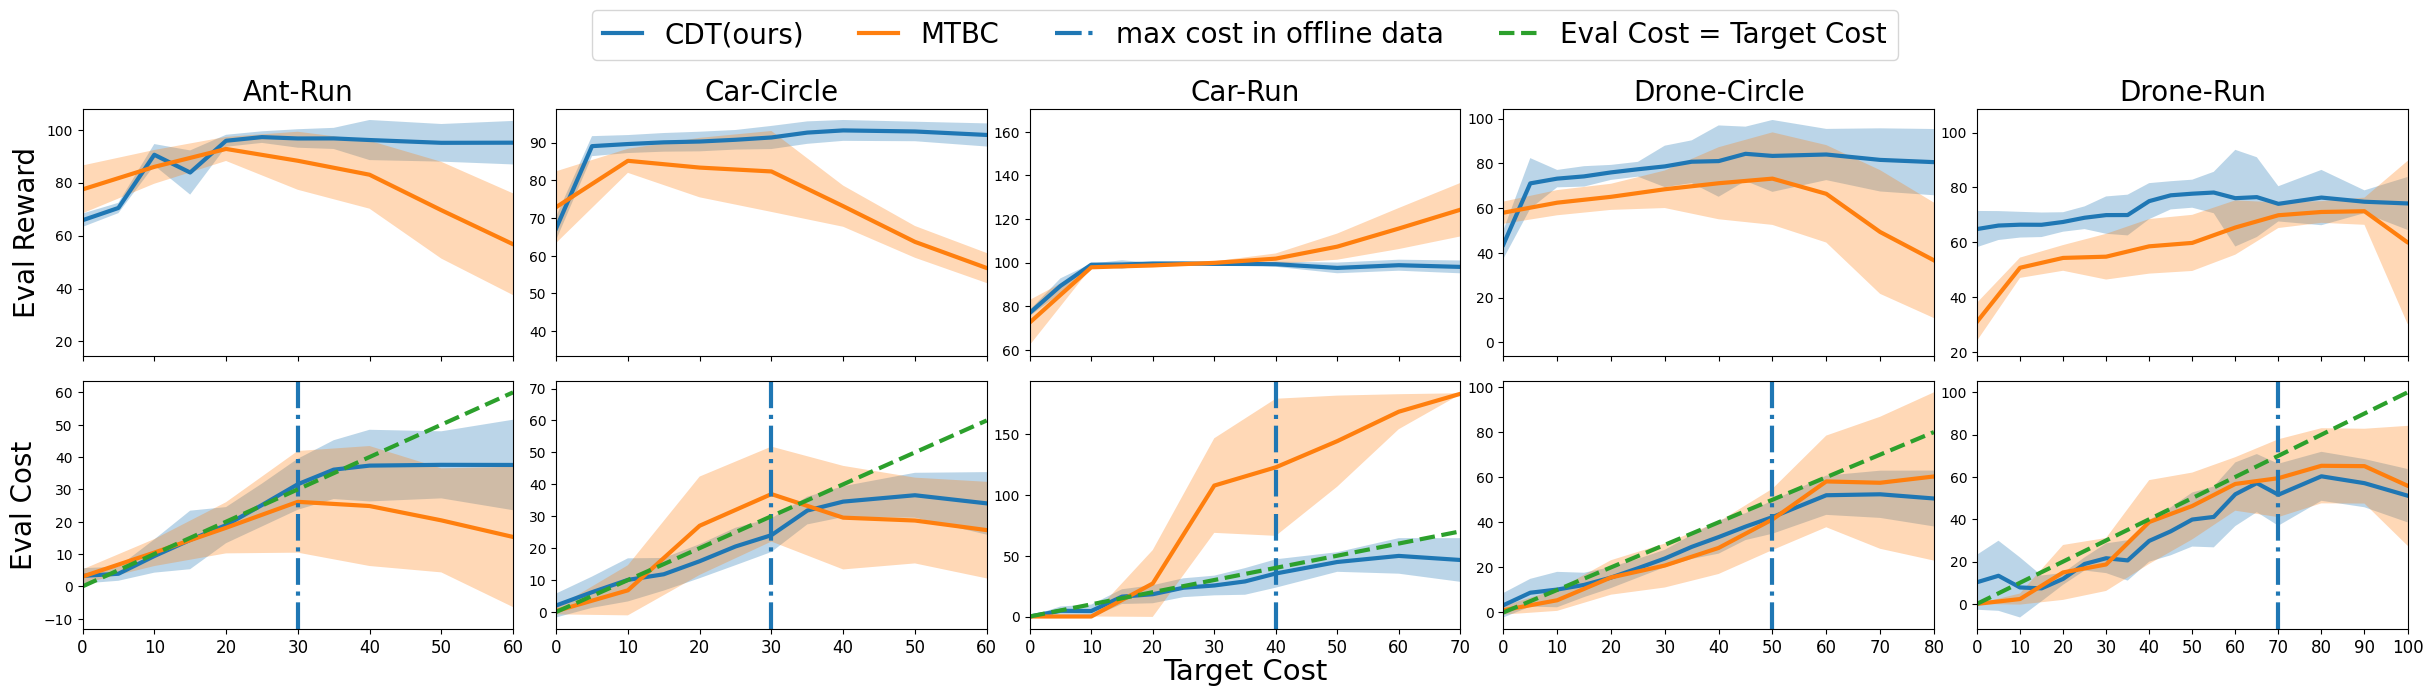

In [620]:
env_names = list(ZeroShot_datasets.keys())

fontsize = 20
xlabelsize = 12
linewidth = 3
fig = plt.figure(figsize=(len(env_names)*6, 8))
gs = fig.add_gridspec(2, len(env_names))
axes = gs.subplots(sharex='col')

for nc, env_name in enumerate(env_names):
    
    axes[0, nc].set_title(env_name, fontsize=fontsize)
    if nc == 0:
        axes[0, nc].set_ylabel("Eval Reward", fontsize=fontsize)

    for exp_name in EXP_NAME_ORDER:
        # reward
        if exp_name not in ZeroShot_datasets[env_name].keys():
            continue
        exp_data = ZeroShot_datasets[env_name][exp_name]["data"]
        x = ZeroShot_datasets[env_name][exp_name]["tc"]
        
        if exp_name == "CDT":
            exp_name += "(ours)"

        # print(f"{exp_name}: reward = {exp_data[0, 1]}, cost = {exp_data[0, 3]}")
        # print(x, exp_data[:, 0])
        axes[0, nc].plot(x, exp_data[:, 0], label=exp_name, linewidth=linewidth)
        axes[0, nc].fill_between(x, 
                                 exp_data[:, 0]-exp_data[:, 1], 
                                 exp_data[:, 0]+exp_data[:, 1], 
                                 alpha=0.3)
        axes[0, nc].set_xlim(x[0], TC_datasets[env_name]+30)
        axes[0, nc].set_xticks([])
        
        # cost
        axes[1, nc].plot(x, exp_data[:, 2], label=exp_name, linewidth=linewidth)
        axes[1, nc].fill_between(x, 
                                 exp_data[:, 2]-exp_data[:, 3], 
                                 exp_data[:, 2]+exp_data[:, 3], 
                                 alpha=0.3)
        axes[1, nc].set_xlim(x[0], TC_datasets[env_name]+30)
        x = np.arange(0,TC_datasets[env_name]+40, 10)
        axes[1, nc].set_xticks(x)

    if nc == 0:
        axes[1, nc].set_ylabel("Eval Cost", fontsize=fontsize)
        # axes[1, nc].set_ylabel("Violation Rate", fontsize=fontsize)
    axes[1, nc].tick_params(axis='x', labelsize=xlabelsize)

    # # cost limit
    axes[1, nc].axvline(x=TC_datasets[env_name], linestyle = '-.', linewidth=linewidth, label="max cost in offline data")
    # x = np.array(x)[np.array(x) <= TC_datasets[env_name]+30]
    axes[1, nc].plot(x, x, linestyle = '--', linewidth=linewidth, label="Eval Cost = Target Cost")
    # axes[1, nc].set_ylim(x[0], x[-1])

plt.subplots_adjust(top=0.8, bottom=0.15, wspace=0.2, hspace=0.1)
plt.legend(ncol=len(EXP_NAME_ORDER), loc='best').set_draggable(True)
plt.legend(
        bbox_to_anchor=(-1.7, 2.5),
        loc='upper center',
        ncol=len(EXP_NAME_ORDER)+2,
        handlelength=1.4,
        borderaxespad=0.,
        prop={'size': fontsize}
        )
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Target Cost", fontsize=fontsize+1)
plt.savefig("zero-shot.png", dpi=500)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

Ablation Study

In [621]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np
from bisect import bisect
pd.options.mode.chained_assignment = None  # default='warn'


DIV_LINE_WIDTH = 50
TR = [300., 350., 400., 450., 500., 550., 600., 650., 700., 750., 800., 850., 900., 1000.]
TC = [10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]
COST_LIMIT = 10.
EPISODE_NUM = 20

ENV_NAME_REPLACE = {
    "SafetyCarCircle-v0": "Car-Circle",
    "SafetyCarRun-v0": "Car-Run",
    "SafetyDroneCircle-v0": "Drone-Circle",
    "SafetyDroneRun-v0": "Drone-Run",
    "SafetyAntCircle-v0": "Ant-Circle",
    "SafetyAntRun-v0": "Ant-Run"
}

# EXP_NAME_REPLACE = {"bcq_lag": "BCQ-Lag", "cpq": "CPQ", "bear_lag": "BEAR-Lag"}
EXP_NAME_ORDER = ["CDT", "CDT_no_sample", "CDT_no_cost", "CDT_no_stochastic", "CDT_no_entropy"] # "CDT_no_aug"
EXP_NAME_REPLACE = {"CDT": "CDT(ours)",
                    "CDT_no_aug": "CDT(no augmentation)"}

# COST_NAME = "EpCost"  # "AverageCost"，"EpCost", "NaturalCost"
# REWARD_NAME = "EpRet"  # "AverageReward"， "EpRet", "NaturalReward"
# NOISE_SCALE = 0
# COST_LIMIT = 0

def get_datasets(logdir: str, datasets: dict):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 
    Assumes that any file "progress.txt" is a valid hit. 
    """
    # global NOISE_SCALE, COST_LIMIT
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:

            for k, v in ENV_NAME_REPLACE.items():
                if k in root:
                    env_name = ENV_NAME_REPLACE[k]

            exp_name = None
            for name in EXP_NAME_ORDER:
                if name+"/" in root:
                    exp_name = name
            if exp_name is None:
                continue
            if "eval" not in root:
                continue
            # if exp_name in EXP_NAME_REPLACE.keys():
            #     exp_name = EXP_NAME_REPLACE[exp_name]
            
            # print(f"valid path = {root}")
            exp_data = pd.read_csv(os.path.join(root, 'progress.txt'))
            # exp_data = exp_data.rename(columns=lambda x: x.split("/")[-1])
            # print(f"{env_name}, {exp_name}")
            if env_name not in datasets.keys():
                datasets[env_name] = {}
            if exp_name not in datasets[env_name].keys():
                datasets[env_name][exp_name] = exp_data
            else:
                datasets[env_name][exp_name] = \
                    pd.concat([datasets[env_name][exp_name], exp_data])

def process_data(exp_data: pd.DataFrame, env_name: str):
    data = np.zeros((len(TR), 4))
    trtc = []
    for i in range(len(TR)):
        name = "TR"+str(TR[i])+"TC"+str(TC[i])
        ret_name  = name+"_EpRet"
        cost_name = name+"_EpCost"
        trtc.append(name)
        ret = exp_data[ret_name].values / MAX_REWARDS[env_name] * 100
        cost = exp_data[cost_name].values / COST_LIMIT

        ret_mean, ret_std = np.mean(ret), np.std(ret)
        cost_mean, cost_std = np.mean(cost), np.std(cost)
        # cost_mean -= COST_LIMIT
        # cost_mean = np.clip(cost_mean, 0, 1e6)
        data[i, :] = [ret_mean, ret_std, cost_mean, cost_std]

        # print("%s EpRet, EpCost = %.3f$\pm$%.3f, %.3f$\pm$%.3f" % (name, ret_mean, ret_std, cost_mean, cost_std))
        print("%s EpRet, EpCost = %.2f, %.2f" % (name, ret_mean, cost_mean))
    res = {"data": data, "trtc": trtc}
    return res


In [622]:
exp_data_dirs_ablation = [
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval",
]

datasets_ablation = {}
for data_dir in exp_data_dirs_ablation:
    # read dataset for each env
    get_datasets(data_dir, datasets_ablation)
# print('='*DIV_LINE_WIDTH)

for env_name, env_data in datasets_ablation.items():
    print(env_name)
    for exp_name, exp_data in env_data.items():
        print(exp_name)
        # print(len(exp_data["CostLimit"]))
        data = process_data(exp_data, env_name)
        env_data[exp_name] = data

Ant-Run
CDT_no_entropy
TR300.0TC10.0 EpRet, EpCost = 45.61, 0.85
TR350.0TC10.0 EpRet, EpCost = 55.66, 0.93
TR400.0TC10.0 EpRet, EpCost = 65.30, 0.84
TR450.0TC10.0 EpRet, EpCost = 71.48, 0.75
TR500.0TC10.0 EpRet, EpCost = 76.20, 0.85
TR550.0TC10.0 EpRet, EpCost = 84.92, 0.83
TR600.0TC10.0 EpRet, EpCost = 92.18, 1.03
TR650.0TC10.0 EpRet, EpCost = 93.42, 1.21
TR700.0TC10.0 EpRet, EpCost = 91.81, 0.95
TR750.0TC10.0 EpRet, EpCost = 89.83, 0.80
TR800.0TC10.0 EpRet, EpCost = 87.47, 0.64
TR850.0TC10.0 EpRet, EpCost = 86.42, 0.65
TR900.0TC10.0 EpRet, EpCost = 85.75, 0.64
TR1000.0TC10.0 EpRet, EpCost = 82.05, 0.62
CDT_no_cost
TR300.0TC10.0 EpRet, EpCost = 46.30, 0.69
TR350.0TC10.0 EpRet, EpCost = 57.09, 0.81
TR400.0TC10.0 EpRet, EpCost = 64.13, 0.72
TR450.0TC10.0 EpRet, EpCost = 70.79, 0.65
TR500.0TC10.0 EpRet, EpCost = 76.65, 0.80
TR550.0TC10.0 EpRet, EpCost = 86.84, 0.91
TR600.0TC10.0 EpRet, EpCost = 92.43, 1.21
TR650.0TC10.0 EpRet, EpCost = 93.08, 1.25
TR700.0TC10.0 EpRet, EpCost = 91.58, 0.9

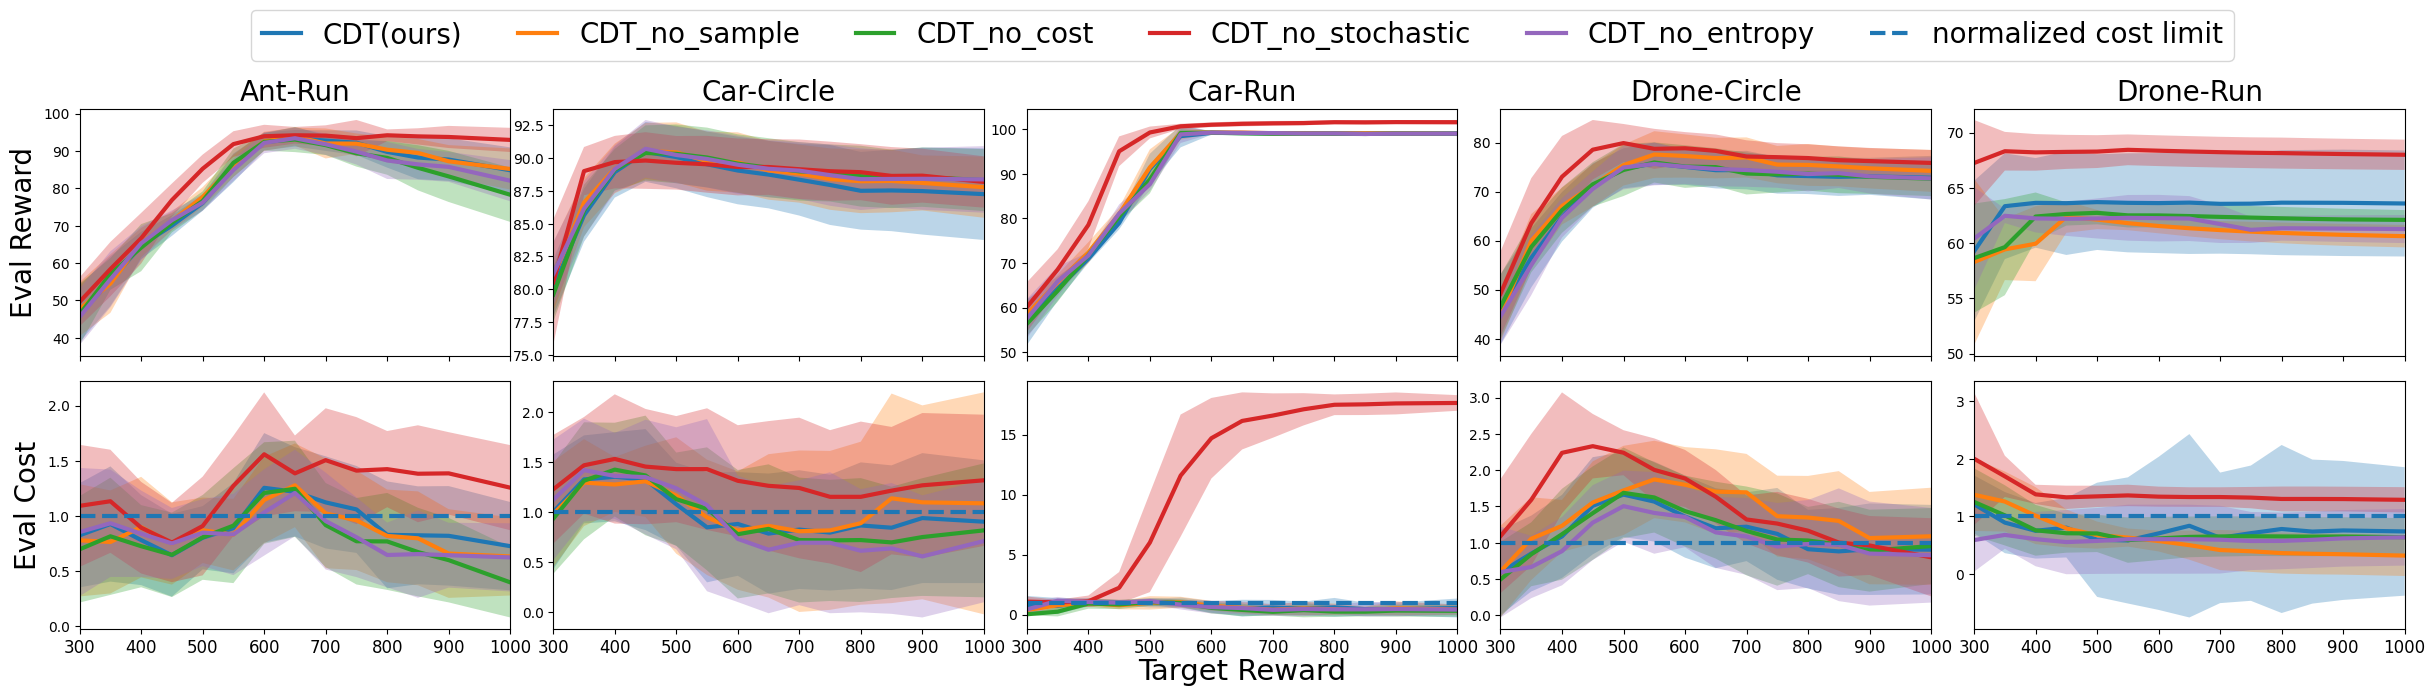

In [623]:
env_names = list(datasets_ablation.keys())

fontsize = 20
xlabelsize = 12
linewidth = 3
fig = plt.figure(figsize=(len(env_names)*6, 8))
gs = fig.add_gridspec(2, len(env_names))
axes = gs.subplots(sharex='col')

for nc, env_name in enumerate(env_names):
    
    axes[0, nc].set_title(env_name, fontsize=fontsize)
    if nc == 0:
        axes[0, nc].set_ylabel("Eval Reward", fontsize=fontsize)

    for exp_name in EXP_NAME_ORDER:
        
        # exp_name = EXP_NAME_REPLACE[exp_name]
        # reward
        if exp_name not in datasets_ablation[env_name].keys():
            continue
        exp_data = datasets_ablation[env_name][exp_name]["data"]

        # if exp_name == "CDT":
        #     exp_name += "(ours)"
        # if exp_name == ""

        if exp_name in EXP_NAME_REPLACE.keys():
            exp_name = EXP_NAME_REPLACE[exp_name]
        # print(f"{exp_name}: reward = {exp_data[0, 1]}, cost = {exp_data[0, 3]}")
        axes[0, nc].plot(TR, exp_data[:, 0], label=exp_name, linewidth=linewidth)
        axes[0, nc].fill_between(TR, 
                                 exp_data[:, 0]-exp_data[:, 1], 
                                 exp_data[:, 0]+exp_data[:, 1], 
                                 alpha=0.3)
        axes[0, nc].set_xlim(TR[0], TR[-1])
        # x = np.arange(0, 1100, 100).tolist()
        # axes[0, nc].set_xlim(x[0], x[-1])
        axes[0, nc].set_xticks([])
        
        # cost
        axes[1, nc].plot(TR, exp_data[:, 2], label=exp_name, linewidth=linewidth)
        axes[1, nc].fill_between(TR, 
                                 exp_data[:, 2]-exp_data[:, 3], 
                                 exp_data[:, 2]+exp_data[:, 3], 
                                 alpha=0.3)
        axes[1, nc].set_xlim(TR[0], TR[-1])
        # axes[0, nc].set_xlim(x[0], x[-1])
        # axes[1, nc].set_xticks(TR)
        x = np.arange(300, 1100, 100).tolist()
        axes[1, nc].set_xticks(x)

    if nc == 0:
        axes[1, nc].set_ylabel("Eval Cost", fontsize=fontsize)
        # axes[1, nc].set_ylabel("Violation Rate", fontsize=fontsize)
    axes[1, nc].tick_params(axis='x', labelsize=xlabelsize)

    # cost limit
    axes[1, nc].axhline(y=1, linestyle = '--', linewidth=linewidth, label="normalized cost limit")

plt.subplots_adjust(top=0.8, bottom=0.15, wspace=0.2, hspace=0.1)
plt.legend(ncol=len(EXP_NAME_ORDER), loc='best').set_draggable(True)
plt.legend(
        bbox_to_anchor=(-1.7, 2.5),
        loc='upper center',
        ncol=len(EXP_NAME_ORDER)+1,
        handlelength=1.4,
        borderaxespad=0.,
        prop={'size': fontsize}
        )
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Target Reward", fontsize=fontsize+1)
# plt.savefig("ablation-augment.png", dpi=500)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

CDT_Noise

In [624]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np
from bisect import bisect
pd.options.mode.chained_assignment = None  # default='warn'


DIV_LINE_WIDTH = 50


ENV_NAME_REPLACE = {
    "SafetyAntCircle-v0": "Ant-Circle",
    "SafetyAntRun-v0": "Ant-Run",
    "SafetyCarCircle-v0": "Car-Circle",
    "SafetyCarRun-v0": "Car-Run",
    "SafetyCarReach-v0": "Car-Reach",
    "SafetyDroneCircle-v0": "Drone-Circle",
    "SafetyDroneRun-v0": "Drone-Run",
}

MAX_REWARDS = {'Ant-Run': 683.23785, 
               'Car-Circle': 490.36856, 
               'Car-Run': 574.6547, 
               'Drone-Circle': 852.11084, 
               'Drone-Run': 486.47946, 
               'Car-Reach': 467.5012}

EXP_NAME_REPLACE = {"bcq_lag": "BCQ-Lag", "cpq": "CPQ", "bear_lag": "BEAR-Lag"}
EXP_NAME_ORDER = ["CDT", "BCQ-Lag", "BEAR-Lag", "CPQ"]

COST_NAME = "EpCost"  # "AverageCost"，"EpCost", "NaturalCost"
REWARD_NAME = "EpRet"  # "AverageReward"， "EpRet", "NaturalReward"
NOISE_SCALE = 0
COST_LIMIT = 10
EPISODE_NUM = 20

def get_datasets(logdir: str, datasets: dict):
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 
    Assumes that any file "progress.txt" is a valid hit. 
    """
    global NOISE_SCALE, COST_LIMIT
    for root, _, files in os.walk(logdir):
        if 'progress.txt' in files:

            if "CDT" not in root:
                config_path = open(os.path.join(root, 'config.json'))
                config = json.load(config_path)

                NOISE_SCALE = config["noise_scale"]
                # COST_LIMIT = config["cost_limit"]

                env_name = config['env_name']
                env_name = ENV_NAME_REPLACE[env_name]

                exp_name = config['policy']
                exp_name = EXP_NAME_REPLACE[exp_name]
            else:
                exp_name = "CDT"
                for k, v in ENV_NAME_REPLACE.items():
                    if k in root:
                        env_name = ENV_NAME_REPLACE[k]
            
            if "eval" not in root:
                continue

            # print(f"valid path = {root}")
            if exp_name == "CDT":
                exp_data = pd.read_csv(os.path.join(root, 'progress.txt'))
            else:
                exp_data = pd.read_table(os.path.join(root, 'progress.txt'))
            exp_data = exp_data.rename(columns=lambda x: x.split("/")[-1])

            if env_name not in datasets.keys():
                datasets[env_name] = {}
            if exp_name not in datasets[env_name].keys():
                datasets[env_name][exp_name] = exp_data
            else:
                datasets[env_name][exp_name] = \
                    pd.concat([datasets[env_name][exp_name], exp_data])

def process_data(exp_data: pd.DataFrame, env_name: str):
    data = np.zeros((len(NOISE_SCALE), 5))
    for i, noise_scale in enumerate(NOISE_SCALE):
        ret_name = "Noise_" + str(noise_scale) + "_EpRet"
        cost_name = "Noise_" + str(noise_scale) + "_EpCost"
        ret = exp_data[ret_name].values / MAX_REWARDS[env_name]
        cost_limit = COST_LIMIT
        if env_name == "Car-Reach":
            cost_limit = 40.
        cost = exp_data[cost_name].values / cost_limit

        # violation = cost > COST_LIMIT
        # # print(violation)
        # # violation_rate_mean = np.sum(violation) / len(violation) * 100
        # violation_each_seed = []
        # for j in range(len(violation)//EPISODE_NUM):
        #     # print(j*EPISODE_NUM, (j+1)*EPISODE_NUM)
        #     violation_each_seed.append( np.sum(violation[j*EPISODE_NUM:(j+1)*EPISODE_NUM]) / EPISODE_NUM )
        # # print(violation_each_seed)
        # # print(np.mean(violation_each_seed) * 100, violation_rate_mean)
        # # assert np.mean(violation_each_seed) * 100 != violation_rate_mean, f"calculation is wrong!"
        # violation_rate_mean = np.mean(violation_each_seed) * 100
        # violation_rate_std = np.std(violation_each_seed) * 100
        ret_mean, ret_std = np.mean(ret), np.std(ret)
        cost_mean, cost_std = np.mean(cost), np.std(cost)
        # cost_mean -= COST_LIMIT
        # cost_mean = np.clip(cost_mean, 0, 1e6)

        data[i, :] = [noise_scale, ret_mean, ret_std, cost_mean, cost_std]
        # data[i, :] = [noise_scale, np.mean(ret), np.std(ret), np.mean(cost), np.std(cost)]
        # data[i, :] = [noise_scale, np.mean(ret), np.std(ret), violation_rate_mean, violation_rate_std]

    return data


In [625]:
exp_data_dirs_noise = [
    # # BCQ-Lag & CPQ (optimal)
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyAntRun-v0_cost_10_optimal_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarCircle-v0_cost_10_v2_optimal_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarRun-v0_cost_10_optimal_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyDroneCircle-v0_cost_10_optimal_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyDroneRun-v0_cost_10_v2_optimal_eval",

    # # Bear-Lag (optimal)
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyAntRun-v0_cost_10_itr_5.pkl_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarCircle-v0_cost_10_itr_7.pkl_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarRun-v0_cost_10_itr_10.pkl_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyDroneCircle-v0_cost_10_itr_9.pkl_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyDroneRun-v0_cost_10_itr_18.pkl_eval",

    # BCQ-Lag & CPQ (last)
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyAntRun-v0_cost_10_last_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyCarCircle-v0_cost_10_v2_last_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyCarRun-v0_cost_10_last_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyDroneCircle-v0_cost_10_last_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyDroneRun-v0_cost_10_v2_last_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarReach-v0_cost_40_last_eval",

    # Bear-Lag (last)
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyAntRun-v0_cost_10_itr_19.pkl_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyCarCircle-v0_cost_10_itr_19.pkl_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyCarRun-v0_cost_10_itr_19.pkl_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyDroneCircle-v0_cost_10_itr_19.pkl_eval",
    "/home/zijian/code/offline-safe-rl/baselines/log/SafetyDroneRun-v0_cost_10_itr_19.pkl_eval",
    # "/home/zijian/codes/offline-safe-rl/baselines/log/SafetyCarReach-v0_cost_40_itr_29.pkl_eval",

    # CDT
    "/home/zijian/code/offline-safe-rl/log/SafetyAntRun-v0_last_eval/2023-01-19_CDT_noise",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarCircle-v0_last_eval/2023-01-19_CDT_noise",
    "/home/zijian/code/offline-safe-rl/log/SafetyCarRun-v0_last_eval/2023-01-19_CDT_noise",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneCircle-v0_last_eval/2023-01-19_CDT_noise",
    "/home/zijian/code/offline-safe-rl/log/SafetyDroneRun-v0_last_eval/2023-01-19_CDT_noise"
]

datasets_noise = {}
for data_dir in exp_data_dirs_noise:
    # read dataset for each env
    get_datasets(data_dir, datasets_noise)
datasets_noise.keys()
datasets_noise["Car-Circle"].keys()
for env_name, env_data in datasets_noise.items():
    # print(env_name)
    for exp_name, exp_data in env_data.items():
        # print(len(exp_data["CostLimit"]))
        data = process_data(exp_data, env_name)
        env_data[exp_name] = data
        

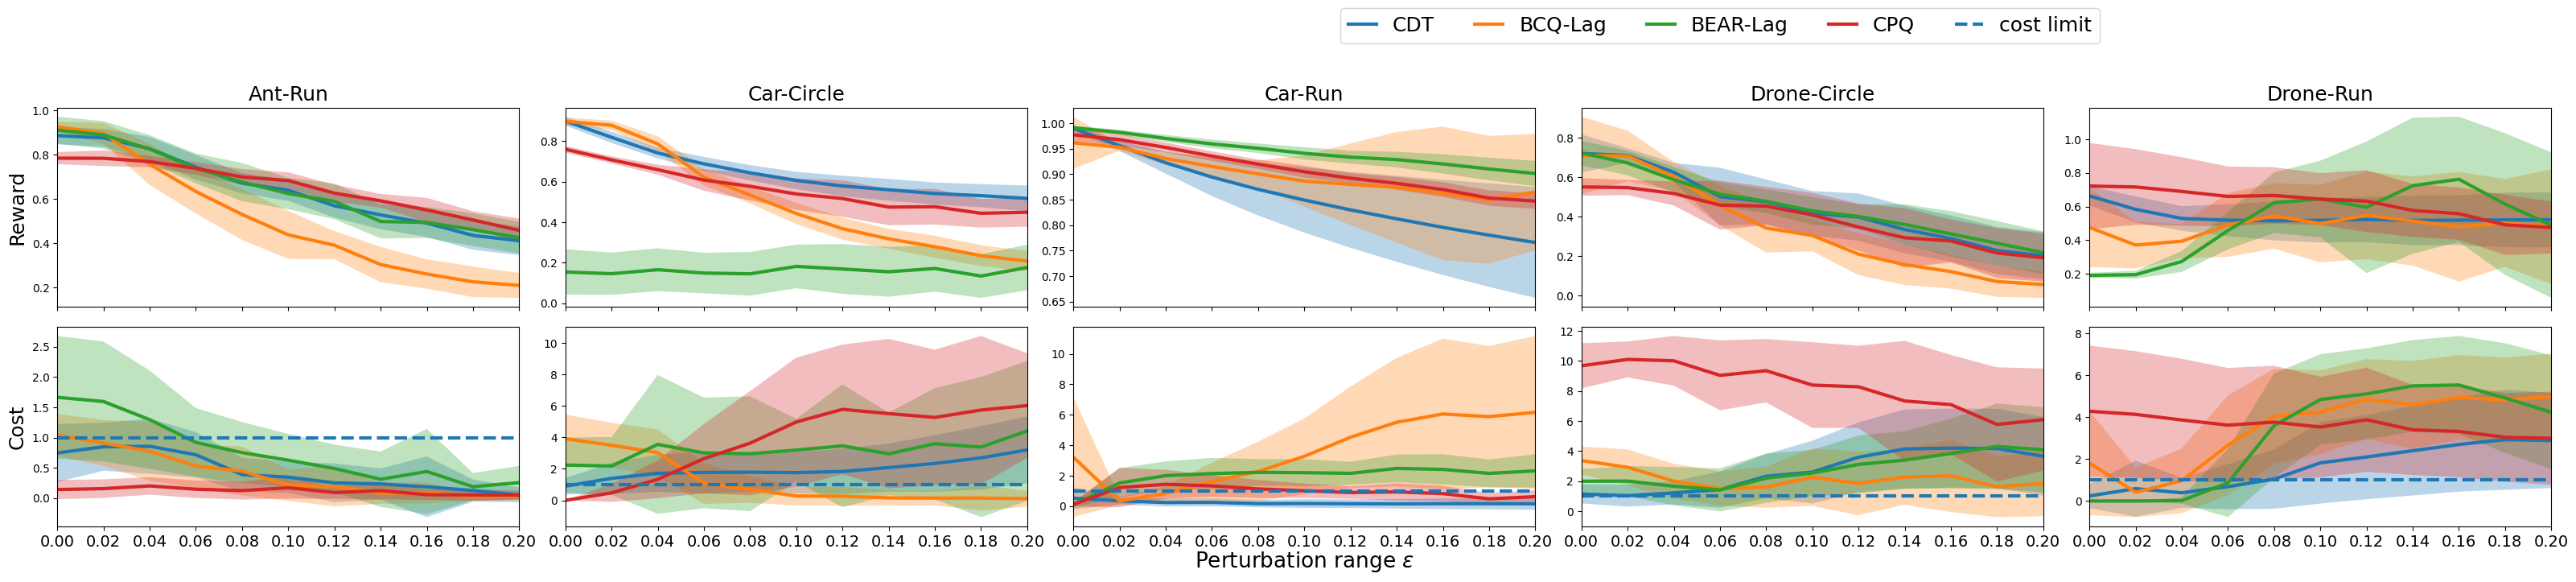

In [626]:
# datasets["Drone-Run"] = datasets["Car-Circle"]
env_names = list(datasets_noise.keys())

fontsize = 18
xlabelsize = 14
linewidth = 3
fig = plt.figure(figsize=(len(env_names)*8, 8))
gs = fig.add_gridspec(2, len(env_names))
axes = gs.subplots(sharex='col')

for nc, env_name in enumerate(env_names):
    
    axes[0, nc].set_title(env_name, fontsize=fontsize)
    if nc == 0:
        axes[0, nc].set_ylabel("Reward", fontsize=fontsize)

    for exp_name in EXP_NAME_ORDER:
        if exp_name not in datasets_noise[env_name].keys():
            continue
        # reward
        exp_data = datasets_noise[env_name][exp_name]
        # print(f"{env_name}, {exp_name}: reward = {exp_data[0, 1]}, cost = {exp_data[0, 3]}")
        axes[0, nc].plot(exp_data[:, 0], exp_data[:, 1], label=exp_name, linewidth=linewidth)
        axes[0, nc].fill_between(exp_data[:, 0], 
                                 exp_data[:, 1]-exp_data[:, 2], 
                                 exp_data[:, 1]+exp_data[:, 2], 
                                 alpha=0.3)
        axes[0, nc].set_xlim([exp_data[:, 0][0], exp_data[:, 0][-1]])
        axes[0, nc].set_xticks([])
        
        # cost
        axes[1, nc].plot(exp_data[:, 0], exp_data[:, 3], label=exp_name, linewidth=linewidth)
        axes[1, nc].fill_between(exp_data[:, 0], 
                                 exp_data[:, 3]-exp_data[:, 4], 
                                 exp_data[:, 3]+exp_data[:, 4], 
                                 alpha=0.3)
        axes[1, nc].set_xlim([exp_data[:, 0][0], exp_data[:, 0][-1]])
        axes[1, nc].set_xticks(exp_data[:, 0])

    if nc == 0:
        axes[1, nc].set_ylabel("Cost", fontsize=fontsize)
        # axes[1, nc].set_ylabel("Violation Rate", fontsize=fontsize)
    axes[1, nc].tick_params(axis='x', labelsize=xlabelsize)

    # cost limit
    axes[1, nc].axhline(y=1, linestyle = '--', linewidth=linewidth, label="cost limit")

plt.subplots_adjust(top=0.8, bottom=0.15, wspace=0.2, hspace=0.1)
plt.legend(ncol=len(EXP_NAME_ORDER), loc='best').set_draggable(True)
plt.legend(
        bbox_to_anchor=(-0.8, 2.6),
        loc='upper center',
        ncol=len(EXP_NAME_ORDER)+1,
        handlelength=1.4,
        borderaxespad=0.,
        prop={'size': fontsize}
        )
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Perturbation range $\epsilon$", fontsize=fontsize+1)
# plt.savefig("/home/zijian/codes/robust-safe-rl/script/figure/results.png")
plt.subplots_adjust(wspace=0.1, hspace=0.1)


CDT_variants

In [627]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# import json
# import os
# import os.path as osp
# import numpy as np
# from bisect import bisect
# from tqdm.auto import trange
# import gym
# import bullet_safety_gym
# from sdt.utils import wrap_env
# from d4srl.offline_env import OfflineEnvWrapper
# from typing import Any, DefaultDict, Dict, List, Optional, Tuple, Union
# from collections import defaultdict
# # from .autonotebook import tqdm as notebook_tqdm
# pd.options.mode.chained_assignment = None  # default='warn'


# DIV_LINE_WIDTH = 50
# TR = [300., 350., 400., 450., 500., 550., 600., 650., 700.]#, 750., 800., 850., 900., 1000.]
# TC = [10., 10., 10., 10., 10., 10., 10., 10., 10.]#, 10., 10., 10., 10., 10.]
# COST_LIMIT = 10.
# EPISODE_NUM = 20

# ENV_NAME_REPLACE = {
#     "SafetyAntCircle-v0": "Ant-Circle",
#     "SafetyAntRun-v0": "Ant-Run",
#     "SafetyCarCircle-v0": "Car-Circle",
#     "SafetyCarRun-v0": "Car-Run",
#     "SafetyCarReach-v0": "Car-Reach",
#     "SafetyDroneCircle-v0": "Drone-Circle",
#     "SafetyDroneRun-v0": "Drone-Run",
#     "ac": "SafetyAntCircle-v0",
#     "ar": "SafetyAntRun-v0",
#     "cc": "SafetyCarCircle-v0",
#     "cr": "SafetyCarRun-v0",
#     "dc": "SafetyDroneCircle-v0",
#     "dr": "SafetyDroneRun-v0",
#     "creach": "SafetyCarReach-v0"
# }
# MAX_REWARDS = {}

# # EXP_NAME_REPLACE = {"bcq_lag": "BCQ-Lag", "cpq": "CPQ", "bear_lag": "BEAR-Lag"}
# EXP_NAME_ORDER = ["optimal", "last"]

# # COST_NAME = "EpCost"  # "AverageCost"，"EpCost", "NaturalCost"
# # REWARD_NAME = "EpRet"  # "AverageReward"， "EpRet", "NaturalReward"
# # NOISE_SCALE = 0
# # COST_LIMIT = 0

# def get_max_rewards(data_dirs: list):
#     global MAX_REWARDS
#     for data_dir in data_dirs:
#         for k, v, in ENV_NAME_REPLACE.items():
#             if k in data_dir.split("/")[-1]:
#                 env_name = ENV_NAME_REPLACE[k]
#                 print(env_name)
#         env = wrap_env(env=gym.make(env_name), reward_scale=1.)
#         env = OfflineEnvWrapper(env)
#         data = env.get_dataset(data_dir)
#         episode_data, info = process_sdt_dataset(data)
#         # returns = [np.max(d["returns"]) for d in episode_data]
#         returns = [d["returns"][0] for d in episode_data]
#         cost_returns = [d["cost_returns"][0] for d in episode_data]
#         cost_limit = 10.
#         if env_name == "SafetyCarReach-v0":
#             cost_limit = 40.
#         mask = np.array(cost_returns) <= cost_limit
#         MAX_REWARDS[ENV_NAME_REPLACE[env_name]] = np.max(np.array(returns)[mask])
#     print(MAX_REWARDS)

# def discounted_cumsum(x: np.ndarray, gamma: float) -> np.ndarray:
#     cumsum = np.zeros_like(x)
#     cumsum[-1] = x[-1]
#     for t in reversed(range(x.shape[0] - 1)):
#         cumsum[t] = x[t] + gamma * cumsum[t + 1]
#     return cumsum

# def process_sdt_dataset(dataset: dict, cost_reverse: bool = False):
#     '''
#     Process the d4rl format dataset to the Sequence dataset that could be 
#     directly used by safe decision transformer training.
#     '''
#     traj, traj_len = [], []
#     data_, episode_step = defaultdict(list), 0
#     for i in trange(dataset["rewards"].shape[0], desc="Processing trajectories"):
#         data_["observations"].append(dataset["observations"][i])
#         data_["actions"].append(dataset["actions"][i])
#         data_["rewards"].append(dataset["rewards"][i])
#         if cost_reverse:
#             data_["costs"].append(1.0 - dataset["costs"][i])
#         else:
#             data_["costs"].append(dataset["costs"][i])

#         if dataset["terminals"][i] or dataset["timeouts"][i]:
#             episode_data = {k: np.array(v, dtype=np.float32) for k, v in data_.items()}
#             # return-to-go if gamma=1.0, just discounted returns else
#             episode_data["returns"] = discounted_cumsum(episode_data["rewards"], gamma=1)
#             episode_data["cost_returns"] = discounted_cumsum(episode_data["costs"], gamma=1)
#             traj.append(episode_data)
#             traj_len.append(episode_step)
#             # reset trajectory buffer
#             data_, episode_step = defaultdict(list), 0
#         episode_step += 1

#     # needed for normalization, weighted sampling, other stats can be added also
#     info = {
#         "obs_mean": dataset["observations"].mean(0, keepdims=True),
#         "obs_std": dataset["observations"].std(0, keepdims=True) + 1e-6,
#         "traj_lens": np.array(traj_len),
#     }
#     return traj, info


# data_dirs = [
#     "/home/zijian/code/offline-safe-rl/dataset/data/ar_cost_0_30_1003.hdf5",
#     "/home/zijian/code/offline-safe-rl/dataset/data/cc_cost_0_30_851.hdf5",
#     "/home/zijian/code/offline-safe-rl/dataset/data/cr_cost_0_40_651.hdf5",
#     "/home/zijian/code/offline-safe-rl/dataset/data/dc_cost_0_50_1243.hdf5",
#     "/home/zijian/code/offline-safe-rl/dataset/data/dr_cost_0_70_796.hdf5",
#     "/home/zijian/code/offline-safe-rl/dataset/data/creach_cost_0_100_2121.hdf5"
# ]
# get_max_rewards(data_dirs)
